### Module import

In [28]:
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image
import cv2
from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

### Load image

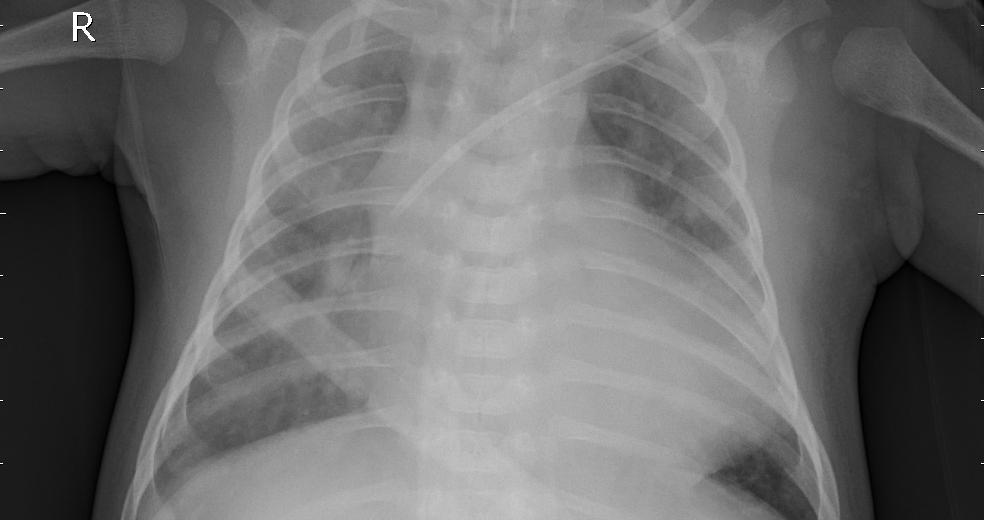

In [29]:
from random import randint
img_dir = 'C:\\Users\\han chang hun\\OneDrive\\source\\repos\\Grad-CAM\\dataset\\chest_xray\\val\\PNEUMONIA' # PNEUMONIA
# img_dir = 'C:\\Users\\han chang hun\\OneDrive\\source\\repos\\Grad-CAM\\dataset\\chest_xray\\val\\NORMAL' # NORMAL
files = os.listdir(img_dir)

rand_num = randint(1,len(files))

img_name = files[rand_num]
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [30]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7') 

Loaded pretrained weights for efficientnet-b7


In [31]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [32]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
if len(np.asarray(pil_img).shape) == 3:
    torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255)
else :
    np_img = np.asarray(pil_img)
    np_img = cv2.cvtColor(np_img,cv2.COLOR_GRAY2RGB)
    torch_img = torch.from_numpy(np_img).permute(2, 0, 1).unsqueeze(0).float().div(255)
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

c:\users\han chang hun\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Load torchvision models and make model dictionaries

In [33]:
alexnet = models.alexnet()
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 2)
alexnet.load_state_dict(torch.load("pth/alexnetch.pth",map_location='cpu')) # use my model parameter and use cpu
alexnet.eval()
# alexnet.cuda()

vgg = models.vgg16()
vgg.classifier[6] = nn.Linear(4096,2)
vgg.load_state_dict(torch.load("pth/vgg16ch.pth",map_location='cpu')) # use my model parameter and use cpu
vgg.eval()
# vgg.cuda()

resnet = models.resnet18()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet.load_state_dict(torch.load("pth/resnet18ch.pth",map_location='cpu'))
resnet.eval()

densenet = models.densenet161()
densenet.classifier = nn.Linear(2208, 2)
densenet.load_state_dict(torch.load("pth/densenet161ch.pth",map_location='cpu')) # use my model parameter and use cpu
densenet.eval()
# densenet.cuda()

squeezenet = models.squeezenet1_1()
squeezenet.classifier[1]  = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = 2
squeezenet.load_state_dict(torch.load("pth/squeezenet1_1ch.pth",map_location='cpu'))
squeezenet.eval()
# squeezenet.cuda()


cam_dict = dict()

alexnet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
alexnet_gradcam = GradCAM(alexnet_model_dict, True)
alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
densenet_gradcam = GradCAM(densenet_model_dict, True)
densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

AssertionError: Torch not compiled with CUDA enabled

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [21]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask,_ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

### Save and show results 

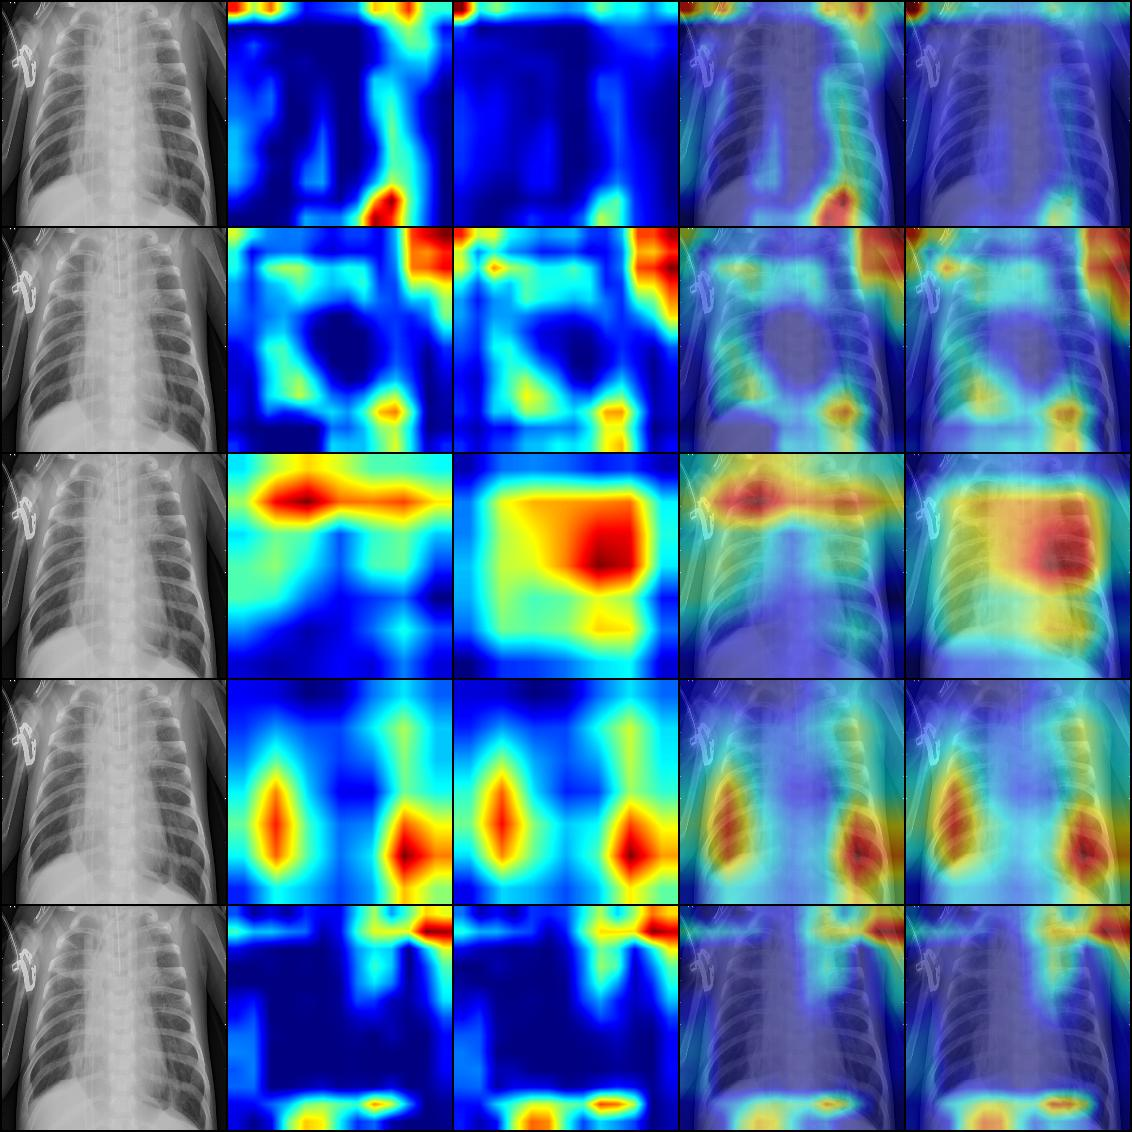

In [22]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

In [23]:
def print_prob(logits):
    for logit in logits:
        h_x = F.softmax(logit, dim=1).data.squeeze()
        probs, idx = h_x.sort(0, True)
        probs = probs.numpy()
        idx = idx.numpy()
        print(probs[0],classes[idx[0]])
        
classes = {int(key):value for (key, value)
          in enumerate(os.listdir(os.path.abspath(os.path.join(img_dir, os.pardir)))[1:])}

logits = [alexnet(normed_torch_img),vgg(normed_torch_img),
          resnet(normed_torch_img),densenet(normed_torch_img),
          squeezenet(normed_torch_img)]

print_prob(logits)

0.9995369 PNEUMONIA
0.99997354 PNEUMONIA
0.99577314 PNEUMONIA
0.99892056 PNEUMONIA
0.9928145 PNEUMONIA


In [11]:
from pathlib import Path

os.listdir(Path(img_dir).parent)[1:]

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [17]:
os.listdir(os.path.abspath(os.path.join(img_dir, os.pardir)))[1:]

['NORMAL', 'PNEUMONIA']